In [1]:
import MDAnalysis as mda
import numpy as np
from numpy.linalg import norm
import pandas as pd
import csv
import freud
import os
import glob
from scipy.optimize import least_squares, curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import sys
import matplotlib.pyplot as plt
import math
import gsd.hoomd
import scipy.optimize as opt
from scipy import stats


In [2]:
path = './'  
dz = .5         
useMax = 0     
numCMs = 10     

In [3]:
cd /lustre/miifs01/project/m2_trr146/achangia/cgSimulations/ctd/200pctd/

/lustre/miifs01/project/m2_trr146/achangia/cgSimulations/ctd/200pctd


In [4]:
pwd

'/lustre/miifs01/project/m2_trr146/achangia/cgSimulations/ctd/200pctd'

In [6]:

def interWidth(x,a,b,c,d):

    return 0.5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)


In [7]:
file_list=[]
for i in range (190,200):
    if os.path.exists('out_{}_dump.gsd'.format(i)):
        print('out_{}_dump.gsd'.format(i))
        file_list.append('out_{}_dump.gsd'.format(i))

out_190_dump.gsd
out_191_dump.gsd
out_192_dump.gsd
out_193_dump.gsd
out_194_dump.gsd
out_195_dump.gsd
out_196_dump.gsd
out_197_dump.gsd
out_198_dump.gsd
out_199_dump.gsd


In [8]:
k=0
for fil_name in file_list:
    try:
        while k<500:

            s1 = gsd.hoomd.open(name= fil_name, mode='rb')
            k =len(s1)+k
            print(fil_name,k)
            #s.extend(s1)
            print(len(s))
            #print(s1[-1].particles.position[-2:])

    except:
        continue

out_190_dump.gsd 1021


In [13]:

cp out_100_200_restart.gsd out_net.gsd

In [14]:
k=0

s = gsd.hoomd.open(name= 'out_net.gsd', mode='rb+')

for fil_name in file_list[:]:
    while k<500:
        try:
            
            
            s1 = gsd.hoomd.open(name= fil_name, mode='rb')
            k =len(s1)+k
            s.extend(s1[:500])
            
        except:
            continue
        
        

In [15]:
s = gsd.hoomd.open(name= 'out_net.gsd', mode='rb+')


In [16]:
u=mda.Universe('out_net.gsd')
u.trajectory

<GSDReader out_net.gsd with 501 frames of 28200 atoms>

In [17]:

nFrames=len(s)

startFrame = 0 #len(s) 

snapshotCount = len(s)

simBox = s[0].configuration.box
masses = s[0].particles.mass
screenTimer = int((snapshotCount - startFrame) / 20)                                                                                                      #?
if screenTimer == 0:
    screenTimer = 1

# Determine number and size of bins
histoVolume = simBox[0] * simBox[1] * dz
histoCount = int(simBox[2] / dz) + 1
histoBins = np.linspace(-simBox[2] / 2.0, simBox[2] / 2.0, num=histoCount)

# Prepare histograms
distribMonomerPos = []
distribMonomerCMPos = []

print('number of frames: ', snapshotCount)

def pos_shift(pos,axis):


    nini=0
    nfin=s[0].particles.position.shape[0]
    #print(pos)
    distribMonomerPos.append(np.histogram(pos[nini:nfin, axis],
                                      bins=histoBins,
                                      weights=masses[nini:nfin],
                                      density=False)[0])

    # Compute density distribution of monomers in lab frame
    distribMonomerPos.append(np.histogram(pos[nini:nfin, axis],
                                  bins=histoBins,
                                  weights=masses[nini:nfin],
                                  density=False)[0])
    # Compute density distribution of monomers in CM frame (first remove CM from box boundaries, then pos-=CM)
    if useMax:
        
        particlesPosShifted = pos[:]
        #print(particlesPosShifted)
        tempDistrib = np.histogram(particlesPosShifted[:, axis], bins=histoBins, weights=masses, density=False)[0]
        maxDensBin = np.argmax(tempDistrib)
        particlesPosShifted[:, axis] = particlesPosShifted[:, axis] - (maxDensBin * dz - simBox[axis] / 2.0)
        particlesPosShifted[particlesPosShifted < -simBox[axis] * 0.5] += simBox[axis]
        particlesPosShifted[particlesPosShifted >  simBox[axis] * 0.5] -= simBox[axis]

        CM = np.mean(particlesPosShifted, axis=0)
        particlesPosShifted = particlesPosShifted - CM
        particlesPosShifted[particlesPosShifted < -simBox[axis] * 0.5] += simBox[axis]
        particlesPosShifted[particlesPosShifted >  simBox[axis] * 0.5] -= simBox[axis]
    else:
        particlesPosShifted = pos[:]
        for j in range(numCMs):
            CM = np.mean(particlesPosShifted, 0)
            particlesPosShifted = particlesPosShifted - CM
            particlesPosShifted[particlesPosShifted < -simBox[axis] * 0.5] += simBox[axis]
            particlesPosShifted[particlesPosShifted >  simBox[axis] * 0.5] -= simBox[axis]

  
    #print(particlesPosShifted)
    return particlesPosShifted



number of frames:  501


In [18]:

Lx,Ly,Lz= s[0].configuration.box[:3] #u.dimensions[2]
lz=Lz
L=15
edges = np.arange(-lz/2,lz/2,1)
dz = (edges[1]-edges[0])/2.
z = edges[:-1]+dz
tmin = 0

tmax = snapshotCount  #len(s)
dt = 1
nt = tmax - tmin


lambda1 = np.zeros(nt) #principal values
lambda2 = np.zeros(nt)
lambda3 = np.zeros(nt)

ax1, ax2, ax3 = np.zeros((nt,3)), np.zeros((nt,3)),np.zeros((nt,3)) #principal axes
tims = 0
natoms=s[0].particles.N

position = np.zeros((nFrames,natoms,3))

j=0
for ts in range (startFrame, snapshotCount):    
    particlesPosShifted_x = pos_shift(s[ts].particles.position,2)

    pos = particlesPosShifted_x[:] #u.atoms.positions[ini_no:fin_no] - u.atoms[ini_no:fin_no].center_of_geometry()
    
    
    hm1 = np.histogram(pos[:,2] ,bins=edges )[0]
    #plt.figure()
    #plt.plot(hm1)
    position[j][:] = pos
    
    j +=1

<Figure size 432x288 with 0 Axes>

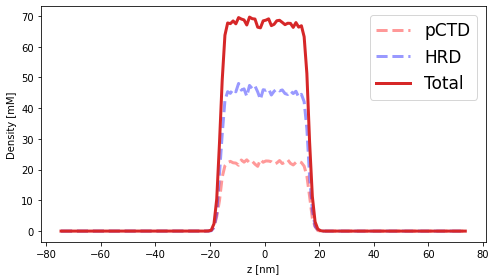

In [19]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 18})

h1 = np.apply_along_axis(lambda a: np.histogram(a,bins=edges)[0], 1, position[:,:14000,2] )
h2 = np.apply_along_axis(lambda a: np.histogram(a,bins=edges)[0], 1, position[:,14000:,2] )
h3 = np.apply_along_axis(lambda a: np.histogram(a,bins=edges)[0], 1, position[:,:,2] )

matplotlib.rcParams.update({'font.size': 23})

hm1 = np.mean(h1[:],axis=0)
hm2 = np.mean(h2[:],axis=0)
hm3 = np.mean(h3[:],axis=0)

plt.figure()
plt.figure(figsize=(7,4))

conv1 = 10/6.022/140/L/L*1e3 #*np.sum(mass_protein_l[0]) /1000

plt.plot(z,conv1*hm1,'r--', linewidth= 3,alpha=.4,label='pCTD')

conv2 = 10/6.022/71/L/L*1e3 #*np.sum(mass_protein_l[0]) /1000
plt.plot(z,conv2*hm2,'b--', linewidth= 3,alpha=.4,label='HRD')

#plt.plot(z,hm2,'r',label='pctd')
plt.plot(z,conv1*hm1+conv2*hm2, c = 'tab:red', linewidth= 3.,label='Total')



plt.legend(fontsize=17)  # Set the legend fontsize to 12 (adjust as needed)
plt.xlabel('z [nm]')
plt.ylabel('Density [mM]')
plt.tight_layout()

plt.savefig('densityPlot_pctd.pdf',dpi=350)


In [22]:
positionParticle = position

def interWidth(x,a,b,c,d):

    return 0.5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)


In [23]:
grid_size = []
list_width_avg=[]
nFrames = positionParticle.shape[0]
Lx,Ly,Lz = s[0].configuration.box[:3]



In [ ]:
def error(hs):
    #np.sum(x[:,5:8])
    
    #[h[h.shape[0]%chunk:][i*chunk:(i+1)*chunk] for i in range(h.shape[0]//chunk)]
    error_den = np.std(hs)/np.sqrt(len(hs))
    return error_den
width_error=[]
intrWid_avg=[]
list_width_avg=[]

for gs in (np.linspace(2,8,10)):
    print(gs)
    # Determine the dimensions of the smaller grids
    grid_size_x = gs
    grid_size_y = gs

    # Calculate the number of grids in each dimension
    num_grids_x = int(Lx / grid_size_x)
    num_grids_y = int(Ly / grid_size_y)



    n_chains1 = 100
    nm1 = 140

    n_chains3 = 200
    nm3 = 71


    histPctd = np.zeros((nFrames, edges.shape[0]-1 )) 
    histctd = np.zeros((nFrames, edges.shape[0]-1 )) 
    histhrd = np.zeros((nFrames, edges.shape[0]-1 )) 
    
    hm1=np.zeros((num_grids_x*num_grids_y, edges.shape[0]-1 ))
    hm2=np.zeros((num_grids_x*num_grids_y, edges.shape[0]-1 ))
    hm3=np.zeros((num_grids_x*num_grids_y, edges.shape[0]-1 ))
    
    list_width=[]
    intrWid=[]

    for nframe in range (500):

        #print(nframe)
        # Iterate over the grids and plot a histogram for each grid
        count = 0
        
        for i in range(num_grids_x):
            for j in range(num_grids_y):

                # Calculate the starting and ending coordinates of the grid
                x_start = -Lx/2+i * grid_size_x
                x_end = x_start + grid_size_x
                y_start =-Ly/2+ j * grid_size_y
                y_end = y_start + grid_size_y
                #print(i,j,x_start,x_end,y_start,y_end)


                particles = positionParticle[nframe][:n_chains1*nm1]
                # Find the particles within the grid
                particles_in_grid_pctd = particles[(x_start <= particles[:, 0]) & (particles[:, 0] < x_end) &
                                              (y_start <= particles[:, 1]) & (particles[:, 1] < y_end) ]


                particles = positionParticle[nframe][n_chains1*nm1:]
                # Find the particles within the grid
                particles_in_grid_hrd = particles[(x_start <= particles[:, 0]) & (particles[:, 0] < x_end) &
                                              (y_start <= particles[:, 1]) & (particles[:, 1] < y_end) ]


                #hm1 = np.histogram(particles_in_grid_ctd[:,2] ,bins=edges )[0]
                hm2 = np.histogram(particles_in_grid_pctd[:,2] ,bins=edges )[0]
                hm3 = np.histogram(particles_in_grid_hrd[:,2] ,bins=edges )[0]

                #         plt.plot( np.histogram(particles_in_grid_pctd[:,2] ,bins=edges )[0])
                #         plt.plot( np.histogram(particles_in_grid_ctd[:,2] ,bins=edges )[0] )
                #         plt.plot( np.histogram(particles_in_grid_hrd[:,2] ,bins=edges )[0] )
                #print(particles_in_grid.shape )
                #plt.plot(hm2)

                ##plt.figure()

                #plt.plot(z,hm2+hm3)
                
                
                count +=1
                z = edges[:-1]+dz
                try:
                    

                    y=hm2+hm3

                    z = edges[:-1]+dz
                    # plt.plot(z,y)

                    ind=(z<0) # & (z>2)
                    y=y[ind]
                    x=z[ind]
 
                    optimizedParameters1, pcov = opt.curve_fit(interWidth, x, y);
 

                    #plt.plot(x, interWidth(x, *optimizedParameters1));

                    y=hm2+hm3

                    z = edges[:-1]+dz
                    # plt.plot(z,y)

                    ind=(z>0) # & (z>2)
                    y=y[ind]
                    x=z[ind]
 
                    optimizedParameters2, pcov = opt.curve_fit(interWidth, x, y);

                    # plt.plot(x, interWidth(x, *optimizedParameters1));

                    # plt.plot(x,y)
                    
                    list_width.append(((optimizedParameters1[3]+optimizedParameters2[3])*.5)**2 )
                
                    #intrWid.append((optimizedParameters1[2]+optimizedParameters2[2])*.5)
     
                    #print(((optimizedParameters1[3]+optimizedParameters2[3])*.5)**2 )
                except:
                    continue
                
    #print(np.array( list_width).mean())
    #intrWid_avg.append( np.array( intrWid).mean() )
    width_error.append( error(np.array( list_width)))
    list_width_avg.append(np.array( list_width).mean())

        

2.0


/cluster/easybuild/broadwell/software/SciPy-bundle/2019.10-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


2.6666666666666665
3.333333333333333
4.0
4.666666666666666


In [ ]:
plt.figure()

plt.plot(z,hm2+hm3,'grey')

y=hm2+hm3

z = edges[:-1]+dz
# plt.plot(z,y)

ind=(z<0) # & (z>2)
y=y[ind]
x=z[ind]

optimizedParameters1, pcov = opt.curve_fit(interWidth, x, y);


#plt.plot(x, interWidth(x, *optimizedParameters1));

y=hm2+hm3

z = edges[:-1]+dz
# plt.plot(z,y)

ind=(z>0) # & (z>2)
y=y[ind]
x=z[ind]

optimizedParameters2, pcov = opt.curve_fit(interWidth, x, y);


plt.plot(x, interWidth(x, *optimizedParameters1),label='fit');

plt.axvline(x=optimizedParameters1[2],c='y')
plt.axvline(x=optimizedParameters1[2]+optimizedParameters1[3],c='g')
plt.axvline(x=optimizedParameters1[2]-optimizedParameters1[3],c='g')

#plt.plot(x,y)

plt.xlabel('z[nm]')
plt.ylabel('Density[mg/ml]')
plt.xlim(5,20)
plt.legend()
plt.tight_layout()
plt.savefig('fit_200.png')


In [ ]:
list_width_avg=np.array(list_width_avg)

In [ ]:
def interfacial_tension(lnR, W0, b, m):
    return W0**2 + m *  ((lnR-b) )

def gamma(R,W2_data,width_error):
    R_data = np.log(R)
    
    initial_guess = [1, 1, 1]

    # curve fit
    params, cov = curve_fit(interfacial_tension, R_data, W2_data,sigma=width_error,absolute_sigma=True)

    # parameters -- W0, b, m 
    W0_fit, b_fit, m_fit = params
    W0_err, b_err, m_err =  [np.sqrt(cov[0][0]), np.sqrt(cov[1][1]), np.sqrt(cov[2][2])]
    

    R_fit = np.linspace(min(R_data), max(R_data), 100)
    W2_fit = interfacial_tension(R_fit, W0_fit, b_fit, m_fit)

    
    ## Find the interfacail tension gamma from m, the slope.
    KB = 1.380649e-23  # Boltzmann constant
    T = 300  # Temperature
    m = m_fit #params[2]
    
    gamma = (KB * T) / (2 * np.pi * m)   ## Unit -- J/nm^2 == Nm/nm^2 == 10^18 * N/m == 10^21 mN/m
    
    # error of gamma:
    error_gamma = (KB * T) / (2 * np.pi * m_fit**2) * m_err

    print(f"Interfacial tension (gamma): {gamma*10**(21)} ± {error_gamma*10**(21)}")
    
    plt.figure(figsize=(7,6))

    plt.scatter(R_data, W2_data )
    formatted_gamma = '{:.2g}'.format(gamma*10**(21))
    formatted_gammaErr = '{:.2g}'.format(error_gamma*10**(21))
    plt.errorbar(R_data, W2_data ,yerr=width_error[:] ,  
                 fmt ='o',markersize=12,markerfacecolor='none', 
                 color='mediumslateblue' ,
                 capsize=2)
    formatted_gammaErr = '{:.2g}'.format(error_gamma*10**(21))
    plt.plot(R_fit, W2_fit, '--',lw=4.5, label=r'$\gamma={}\pm{} $'.format(formatted_gamma ,formatted_gammaErr ) )
    plt.xlabel(r'ln B [nm]')
    plt.ylabel(r'W$^{2}$ [nm$^{2}$]')
    plt.legend()
    #plt.show()
    plt.tight_layout()
    plt.savefig('w2_pctd_ctd_200.png',dpi=300)
    return gamma,error_gamma
    
    

In [41]:
w2=list_width_avg
l=np.linspace(2,8,10) #[3,4,5,6,7]

In [ ]:
width_error=np.array(width_error)

In [ ]:
plt.rcParams.update({'font.size': 23})

Gamma,err = gamma(l[2:],w2[2:],width_error[2:])

print('gamma = ',Gamma*10**(21) ,'mN/m')


In [ ]:
Gamma,err = gamma(l[2:],w22[2:],width_error[2:])


gamma =  1.0520401845617509 mN/m


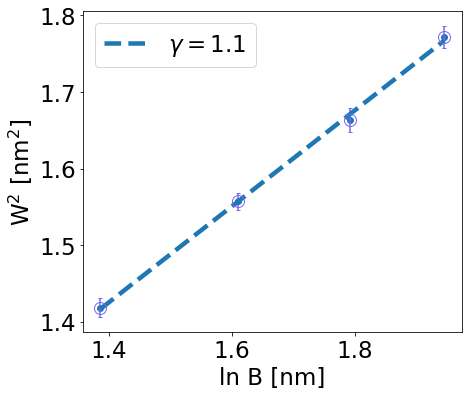

In [155]:
plt.rcParams.update({'font.size': 23})

Gamma = gamma(l[1:],w2[1:])

print('gamma = ',Gamma*10**(21) ,'mN/m')

